# Determining IceVision Bounding Box Model Effectiveness 

In [ ]:
#all_slow

For the IceVision Bounding Boxes, we created a juypter notebook based off of IceVision's [Custom Parser](https://airctic.com/0.8.0/custom_parser/) and [Getting Started (Object Detection)](https://airctic.com/0.8.0/getting_started_object_detection/) notebooks.

To test which IceVision model was the most effective at identifying our data, we ran our cleaned data through four various models with five k-folds using four various k-fold cross-validation values. During this process, we used wandb to track each run so that we could compare the effectiveness of each model from run to run.

The first step in this process was to download IceVision as well as our espiownage data, which was carried out with the following code:





In [ ]:
! [ -e /content ] &&  wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
! [ -e /content ] &&  chmod +x install_colab.sh && ./install_colab.sh 
! [ -e /content ] &&  pip install git+git://github.com/airctic/icevision.git --upgrade && kill -9 -1

--2021-09-28 05:56:21--  https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1244 (1.2K) [text/plain]
Saving to: ‘install_colab.sh’

install_colab.sh    100%[===================>]   1.21K  --.-KB/s    in 0s      

2021-09-28 05:56:21 (34.7 MB/s) - ‘install_colab.sh’ saved [1244/1244]

Installing icevision + dependencices for CUDA 10
Uninstalling some dependencies to prevent errors
Found existing installation: torchvision 0.10.0+cu102
Uninstalling torchvision-0.10.0+cu102:
  Successfully uninstalled torchvision-0.10.0+cu102
Found existing installation: fastai 1.0.61
Uninstalling fastai-1.0.61:
  Successfully uninstalled fastai-1.0.61
Installing some dependencies to prevent errors
     |██

The code above was used to install IceVision, detect if the user running the code was on Google Colab or not, and to also restart the notebook.

Following this, we installed the espiownage packages and defined our run parameters. At this point, we also defined a wandb project so that we could compare each run to determine which model was most effective.

In [ ]:
dataset_name = 'cleaner'  # choose from: cleaner, preclean, spnet, cyclegan, fake
k = 4               # for k-fold cross-validation
model_choice = 0    # IceVision object detector backbone; see below
nk = 5              # number of k-folds (leave as 5)
use_wandb = True    # can set to false if no WandB login/tracking is desired
project = 'bbox_kfold' # project name for wandb

We then proceeded to import the IceVision packages as well as the pandas packages as well as a process to check if the user running the notebook was either on colab or not.

In [ ]:
from icevision.all import *  
import pandas as pd
from mrspuff.utils import on_colab
from icevision.models.checkpoint import *

After the previous cell ran, the location of the dataset was defined and IceVision was directed to read in the training data.

Following this, the dataset was shuffled and objects within the dataset were classified as antinodes so that our k-folding process worked effectively.

In [ ]:
df = pd.read_csv(data_dir / "bboxes/annotations.csv")
df = df.sample(frac=1).reset_index(drop=True) 
df['label'] = 'AN' 
df.head()

Afterwards, the parser for IceVision was defined.

In [ ]:
template_record = ObjectDetectionRecord()

class BBoxParser(Parser):
    def __init__(self, template_record, data_dir):
        super().__init__(template_record=template_record)
        
        self.data_dir = data_dir
        self.df = pd.read_csv(data_dir / "bboxes/annotations.csv")
        self.df['label'] = 'AN'  
        self.df = self.df.sample(frac=1).reset_index(drop=True)  
        self.class_map = ClassMap(list(self.df['label'].unique()))
        
    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o
        
    def __len__(self) -> int:
        return len(self.df)
        
    def record_id(self, o) -> Hashable:
        return o.filename
        
    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(self.data_dir / 'images' / o.filename)
            record.set_img_size(ImgSize(width=o.width, height=o.height))
            record.detection.set_class_map(self.class_map)
        
        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels([o.label])

parser = BBoxParser(template_record, data_dir)

Once the parser was defined, the dataset was split with five various k-fold values ranging from k = 0 to k = 4, one less than the number of k-folds. 

In [ ]:
kfold = True 
k = 4  # manual k-folding index -- change this yourself k = 0 to (nk-1)
    nk = 5 # number of k-folds
    print(f"\n-----\n K-fold splitting: {k+1}/{nk}")
    n = len(df)
    idmap, indlist = IDMap(list(df['filename'][0:n])), list(range(n))
    val_size = int(round(n/nk))

    if k < nk-1:
        val_list = indlist[k*val_size:(k+1)*val_size]
        train_list = indlist[0:k*val_size] + indlist[(k+1)*val_size:n]
    else:   
        val_list = indlist[k*val_size:]
        train_list = indlist[0:-len(val_list)]
    val_id_list = list([df['filename'][i] for i in val_list])
    train_id_list = list([df['filename'][i] for i in train_list])
    presplits = list([train_id_list,val_id_list])
    train_records, valid_records = parser.parse(data_splitter=FixedSplitter(presplits))

We then defined and applied transformations to the data so that IceVision did not accidentally detect the image borders and instead detected the anodes in each image. At this point, we also defined the new, split dataset.

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384  
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_=size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

At this point, we created a cell so that our model selection number, which was defined earlier in our run parameters, could actually set which model IceVision would use to train.

Models were defined as follows:


> Retinanet = Model Selection 0


> Retinanet = Model Selection 1



> Efficientdet = Model Selection 2


> Yolov5 = Model Selection 3



(Note: Both Efficientdet and Yolov5 require image size parameters whereas Retinanet does not.)


The following cell shows the code behind this process.

In [ ]:
selection = model_choice
extra_args = {}

if selection == 0:
    model_type = models.mmdet.retinanet
    backbone = model_type.backbones.resnet50_fpn_1x
    model_name='mmdet.retinanet'
    backbone_name = 'resnet50_fpn_1x'

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
    model_type = models.torchvision.retinanet
    backbone = model_type.backbones.resnet50_fpn
    model_name='torchvision.retinanet'
    backbone_name = 'resnet50_fpn'

elif selection == 2:
    model_type = models.ross.efficientdet
    backbone = model_type.backbones.tf_lite0
    # The efficientdet model requires an img_size parameter
    model_name='ross.efficientdet'
    backbone_name = 'tf_lite0'
    extra_args['img_size'] = image_size

elif selection == 3:
    model_type = models.ultralytics.yolov5
    backbone = model_type.backbones.small
    model_name='ultralytics.yolov5'
    backbone_name = 'small'
    # The yolov5 model requires an img_size parameter
    extra_args['img_size'] = image_size

model_type, backbone, extra_args

Wandb was then initialized after model selections were defined so that each run could be tracked and the model was then instantiated.

In [ ]:
if use_wandb: 
    !pip install wandb -qqq
    import wandb
    from fastai.callback.wandb import *
    from fastai.callback.tracker import SaveModelCallback
    wandb.login()
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

Then, dataloaders were defined.

In [ ]:
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

Once the dataloaders were defined, metrics for each wandb run were defined.

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

After defining metrics, a wandb run was initalized so that the training runs could be tracked.

In [ ]:
if use_wandb:
    wandb.init(project=project, name=f'k=4,m={model_choice},{dataset_name}')
    cbs = [WandbCallback()]
else:

    cbs = []

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics, 
            cbs=cbs)

The next step was to then begin training the data with 11 epochs using a learning rate of 1e-4, with two frozen epochs.

In [ ]:
epochs = 11 if kfold else 30  
lr = 1e-4
freeze_epochs=2
print(f"Training for {epochs} epochs, starting with {freeze_epochs} frozen epochs...")
learn.fine_tune(epochs,lr, freeze_epochs=2)

Once a run was concluded, the respective wandb run was terminated so that a new run could be tracked.

In [ ]:
wandb.finish()

This process was then repeated 19 times for each model with various k-values ranging from 0 to nk-1.

After 20 total runs of the clean data were preformed with the various models and k-values, the COCOMetric of each run was compared to the others to determine which learning model taught the neural network best. From this, it was concluded that model number = 0 (mmdet's Retinanet) taught our neural network better than any of the other models.

The results of each run can be seen below. 

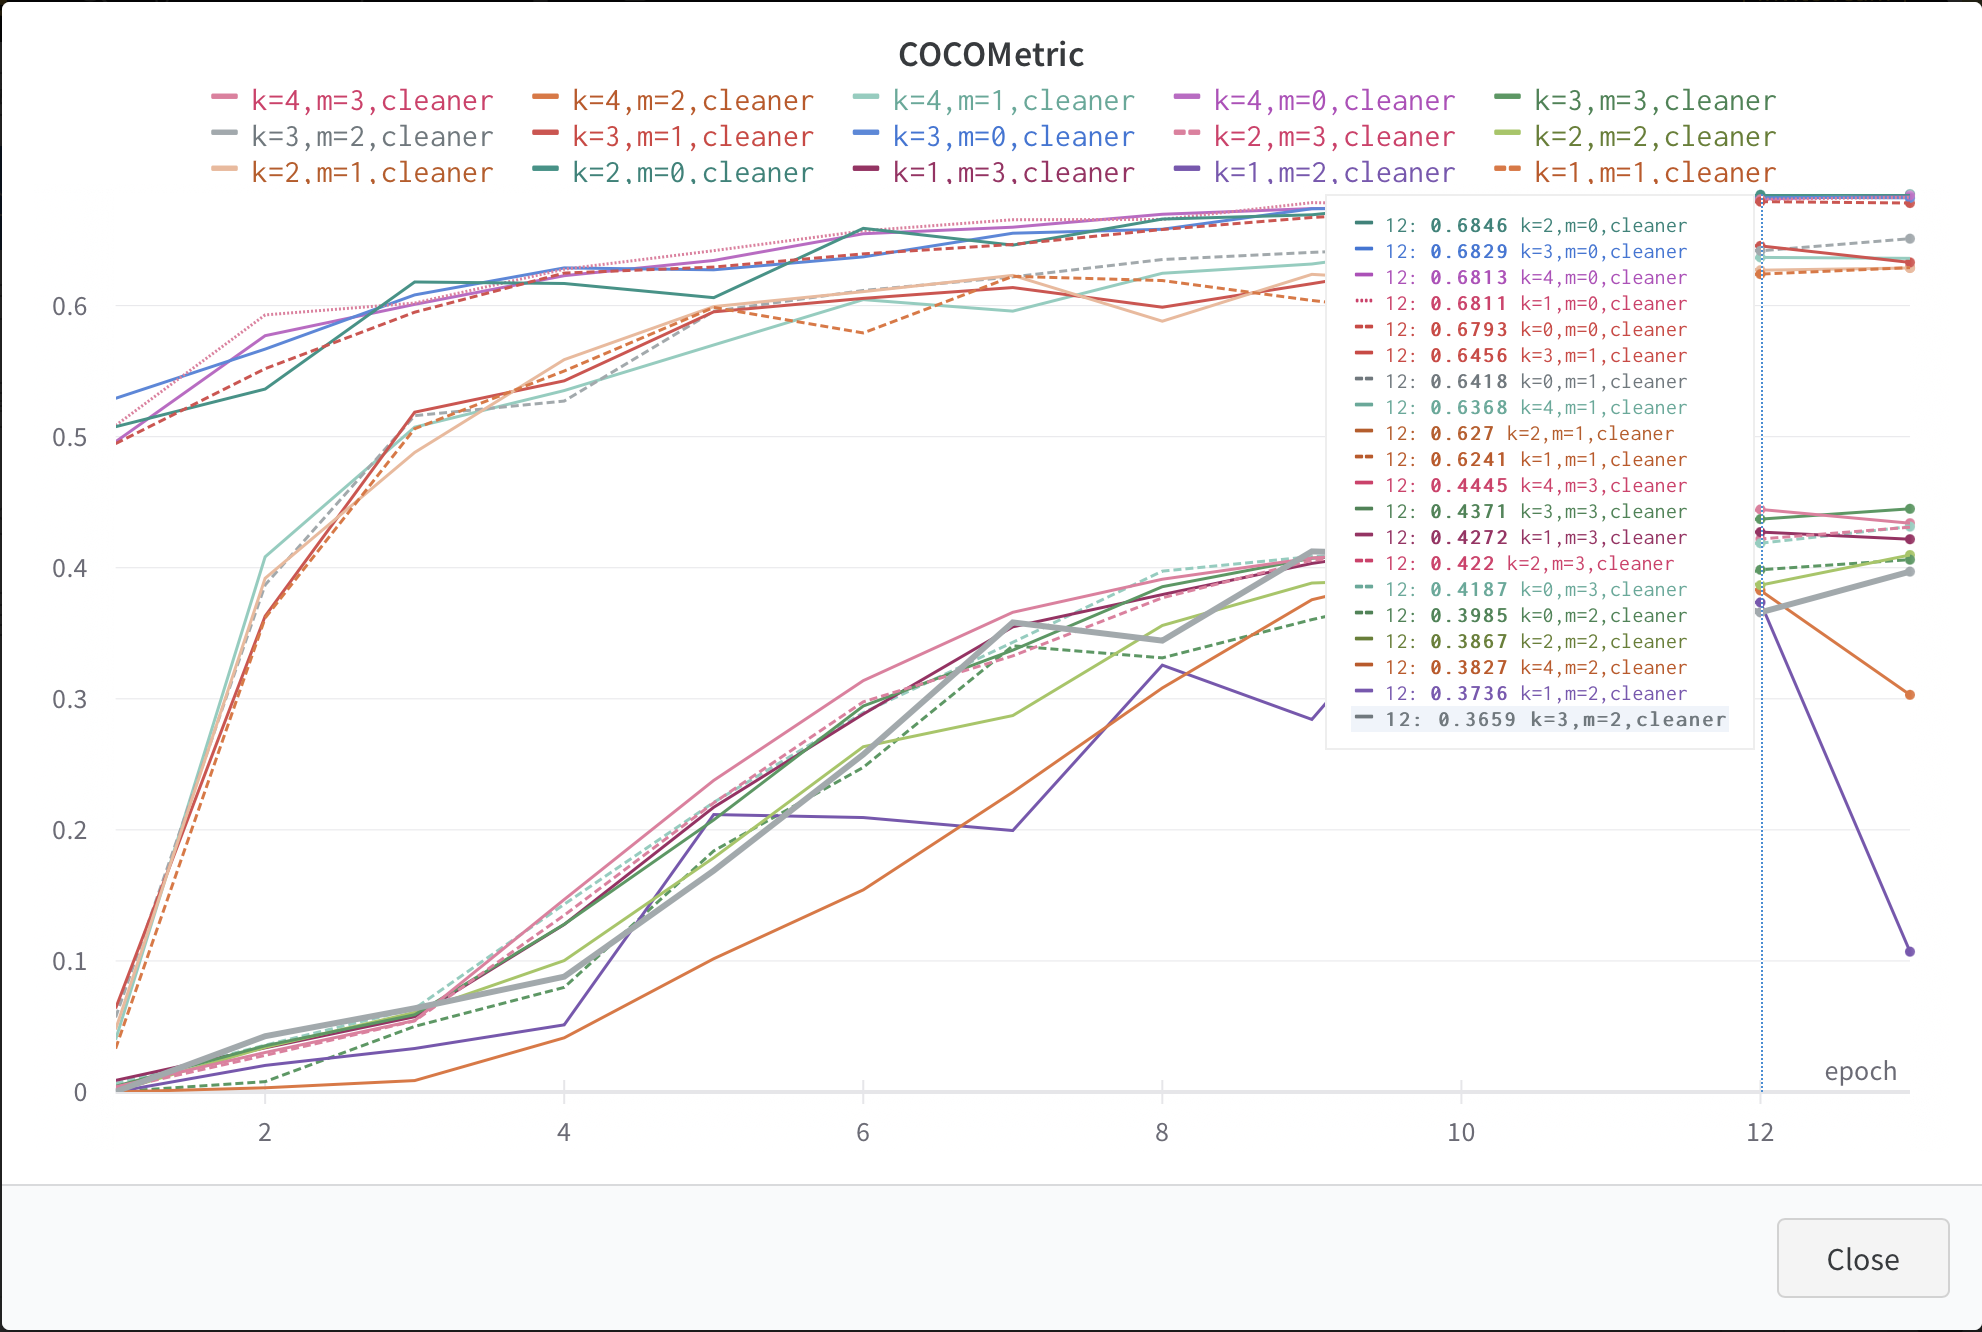

We found that mmdet's Retinanet preformed best with an average COCOMetric of 0.68184 with a standard deviation of 0.002. Expectedly, torchvision's Retinanet preformed second best with an average COCOMetric of 0.63506 and standard deviation of 0.00928 across all runs. From these results, it was decided that mmdet's Retinanet would be used to train our neural network to fit IceVision Bounding Boxes around antinodes in our data for all data sets.